In [1]:
import pandas as pd
import numpy as np
from processing import get_images, create_labeled_example, create_labeled_pair
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

import json
import subprocess

In [46]:
df, images = get_images(csv_path='./annotations/urbach.csv', clahe=False)
data = df
print(f'training with {len(data)} craters')

training with 3658 craters


In [49]:
def datagen(data, batch_size = 1, scale=256):
    while True:
        X = []
        Y = []
        ub = scale//4
        lb = scale//8
        data = data[(df.r>lb)&(df.r<ub)]
        for i, row in data.sample(n=batch_size, replace=True).iterrows():
            sf = scale//32
            img = images[row['source']]
            gt_center = row['x'], row['y']
            shift_min = 0-(scale//8 - 1)
            shift_max = (scale//8)
            prop_center = (
                round(row['x']) + 0,#np.random.randint(shift_min, shift_max), 
                round(row['y']) + 0#np.random.randint(shift_min, shift_max)
            )
            gt_radius = row['r']
            extr, label = create_labeled_pair(img, gt_center, prop_center, gt_radius, scale)
            extr = extr[:, :, 0:1]
            suby, subx = 0, 0
            movx = (sf-subx)/sf
            movy = (sf-suby)/sf
            label = np.array([label[0]+movx, label[1]+movy, label[2]])
            trans = 15
            label = (label[0] + trans, label[1] + trans, label[2]*32)
            X.append(np.expand_dims(extr, axis=0))
            Y.append(np.expand_dims(label, axis=0))
        X = np.concatenate(X)
        Y = np.concatenate(Y)
        yield X, Y.reshape(batch_size, -1)

In [20]:
x_, y_ = next(gen)

In [27]:
gen = datagen()
x_, y_ = next(gen)
px = x_[0, :, :, 0]
px = px.flatten().tolist()

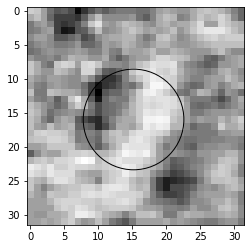

In [58]:
def get_sub_imgs(img):
    scale = img.shape[0]
    sf = scale//32
    sub_images = []
    for i in range(sf):
        for j in range(sf):
            sub_image = img[j::sf,i::sf]
            sub_image = sub_image.reshape(1, -1)
            sub_images.append(sub_image)
    sub_images = np.concatenate(sub_images)
    return sub_images

def make_request(array):
    data = {
        "instances":array.tolist()
    }
    data_json = json.dumps(data)
    path = './tmp.json'
    with open(path, 'w') as f:
        f.write(data_json)
    
    base_url = "http://localhost:8501/v1/models/craters:predict"
    cmd = f"curl -d '@{path}' -X POST {base_url}"
    response = subprocess.check_output(cmd, shell=True).decode()
    response_data = eval(response)
    return response_data

def parse_predictions(predictions, sf):
    pred = np.array([np.array(x) for x in predictions])
    pred = pred.mean(axis=0)
    pred = pred * sf
    return pred

def handle_pixels(px):
    allowed = [1024,  4096, 16384, 65536]
    dim = len(px)
    if dim not in allowed:
        raise Exception('Unable to parse dim; array should have length of: ' + str(allowed))
    scale = int(np.sqrt(dim))
    sf = scale//32
    img = np.array(px).reshape(scale, scale)
    sub_imgs = get_sub_imgs(img)
    response = make_request(sub_imgs)
    predictions = response['predictions']
    pred = parse_predictions(predictions, sf)
    return pred

scale = 32
gen = datagen(data, scale=scale)
x_, y_ = next(gen)
px = x_[0, :, :, 0]
px = px.flatten().tolist()
    
pred = handle_pixels(px)
circle = Circle((pred[0], pred[1]), pred[2], fill=False)
fig, ax = plt.subplots()
ax.imshow(np.array(px).reshape(scale, scale), cmap='Greys_r');
ax.add_artist(circle)

256 8


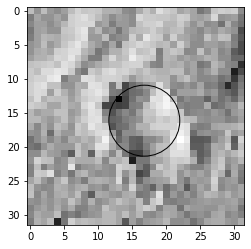

In [9]:
def get_sub_imgs(img):
    scale = img.shape[0]
    sf = scale//32
    print(scale, sf)
    sub_images = []
    for i in range(sf):
        for j in range(sf):
            sub_image = img[j::sf,i::sf]
            sub_image = sub_image.reshape(1, -1)
            sub_images.append(sub_image)
    sub_images = np.concatenate(sub_images)
    return sub_images

def make_request(array):
    data = {
        "instances":[array.tolist()]
    }
    data_json = json.dumps(data)
    path = './tmp.json'
    with open(path, 'w') as f:
        f.write(data_json)
    
    base_url = "http://localhost:8501/v1/models/craters:predict"
    cmd = f"curl -d '@{path}' -X POST {base_url}"
    response = subprocess.check_output(cmd, shell=True).decode()
    response_data = eval(response)
    return response_data

img = x_[2][:, :, 0]
img.shape

out = get_sub_imgs(img)
tst = out[1]
fig, ax = plt.subplots()
ax.imshow(tst.reshape(32, 32), cmap="Greys_r")
response = make_request(tst)
x, y, r = response['predictions'][0]
circle = Circle((x,y), r, fill=False)
ax.add_artist(circle)
plt.show()

In [6]:
def make_request(array):
    data = {
        "instances":array.tolist()
    }
    data_json = json.dumps(data)
    path = './tmp.json'
    with open(path, 'w') as f:
        f.write(data_json)
    
    base_url = "http://localhost:8501/v1/models/craters:predict"
    cmd = f"curl -d '@{path}' -X POST {base_url}"
    response = subprocess.check_output(cmd, shell=True).decode()
    response_data = eval(response)
    return response_data

response = make_request(out)

In [7]:
def parse_predictions(predictions):
    pred = np.array([np.array(x) for x in predictions])
    pred = pred * 8
    pred = pred.mean(axis=0)
    return pred

out = parse_predictions(response['predictions'])

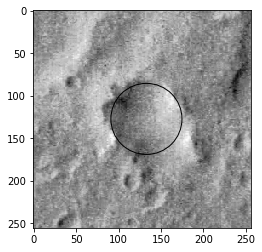

In [8]:
fig, ax = plt.subplots()

ax.imshow(img, cmap='Greys_r')
circle = Circle((out[0], out[1]), out[2], fill=False)
ax.add_artist(circle)
plt.show()